In [ ]:
import sympy as sym
from IPython.display import display


# ###################################################################
def cubic_spline(xs: list[float], ys: list[float]) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x

    xs = [x for x, _ in points]
    ys = [y for _, y in points]

    n = len(points) - 1  # number of splines

    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0] * (n + 1)  # coefficients for the system of equations 
    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [1]
    u = [0]
    z = [0]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z   = [alpha[i] - h[i - 1] * z[i - 1] / l[i]] + z

    l.append(1)
    z.append(0)
    c = [0] * (n + 1)

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a   = ys[j] 
        print(j, a, b, c[j], d)
        S  =  a + b * (x - xs[j]) + c[j] * (x - xs[j])**2 + d * (x - xs[j])**3    

        splines.append(S)
    splines.reverse()
    return splines

In [2]:
xs = [0, 1, 2]
ys = [-5, -4, 3]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 -4 7.0 0.0 0.0
0 -5 -11.0 18.0 -6.0


-6.0*x**3 + 18.0*x**2 - 11.0*x - 5

7.0*x - 11.0

______


-6.0*x**3 + 18.0*x**2 - 11.0*x - 5

7.0*x - 11.0

#####Grafico 1


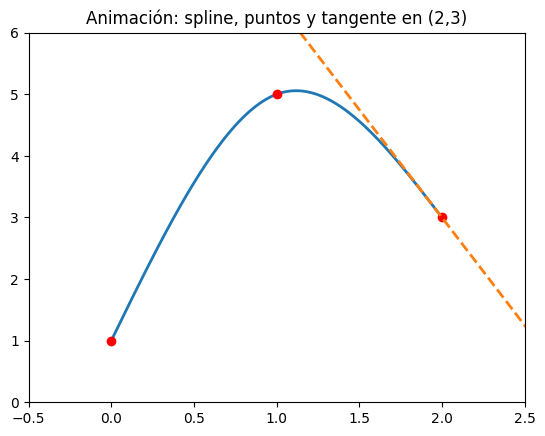

In [3]:
# — Celda 3 (completamente autónoma) —
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 1) Defino de nuevo mis puntos y la función cubic_spline
def cubic_spline(xs: list[float], ys: list[float]):
    xs, ys = zip(*sorted(zip(xs, ys)))
    xs, ys = list(xs), list(ys)
    n = len(xs) - 1
    h = [xs[i+1] - xs[i] for i in range(n)]
    alpha = [0]*(n+1)
    for i in range(1, n):
        alpha[i] = (3/h[i])*(ys[i+1]-ys[i]) - (3/h[i-1])*(ys[i]-ys[i-1])
    l = [1] + [0]*n
    mu = [0]*(n+1)
    z = [0]*(n+1)
    for i in range(1, n):
        l[i] = 2*(xs[i+1]-xs[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1]) / l[i]
    l[n], z[n] = 1, 0
    c = [0]*(n+1); b = [0]*n; d = [0]*n
    a = ys[:-1]
    x = sym.Symbol('x')
    S = []
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (ys[j+1]-ys[j])/h[j] - h[j]*(c[j+1]+2*c[j])/3
        d[j] = (c[j+1]-c[j])/(3*h[j])
        Sj = a[j] + b[j]*(x-xs[j]) + c[j]*(x-xs[j])**2 + d[j]*(x-xs[j])**3
        S.insert(0, sym.simplify(Sj))
    return xs, ys, S

# 2) Calculo los splines para mis puntos
xs, ys, splines = cubic_spline([0,1,2], [1,5,3])

# 3) Preparo la animación (exactamente igual que antes)
x = sym.Symbol('x')
S_last = splines[-1]
f_last = sym.lambdify(x, S_last, 'numpy')
f_prime_last = sym.lambdify(x, sym.diff(S_last, x), 'numpy')
x0, y0 = xs[-1], ys[-1]
m0 = f_prime_last(x0)

# Datos de la curva completa
xs_fine = np.linspace(xs[0], xs[-1], 300)
ys_full = np.empty_like(xs_fine)
for j, Sj in enumerate(splines):
    mask = (xs_fine>=xs[j])&(xs_fine<=xs[j+1])
    ys_full[mask] = sym.lambdify(x, Sj, 'numpy')(xs_fine[mask])

fig, ax = plt.subplots()
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(min(ys)-1, max(ys)+1)
ax.set_title('Animación: spline, puntos y tangente en (2,3)')
line_spline, = ax.plot([], [], lw=2)
pts, = ax.plot([], [], 'o', color='red')
tangent, = ax.plot([], [], '--', lw=2)

def init():
    line_spline.set_data([], [])
    pts.set_data([], [])
    tangent.set_data([], [])
    return line_spline, pts, tangent

def update(frame):
    N = len(xs_fine)
    if frame < N:
        line_spline.set_data(xs_fine[:frame], ys_full[:frame])
    else:
        k = frame - N
        pts.set_data(xs[:k], ys[:k])
        if k >= len(xs):
            t = (k-len(xs))/(N/10)
            t = min(max(t,0),1)
            L = t*1.0
            xv = np.array([x0-L, x0+L])
            yv = y0 + m0*(xv-x0)
            tangent.set_data(xv, yv)
    return line_spline, pts, tangent

total_frames = len(xs_fine) + len(xs) + int(len(xs_fine)/10)
anim = FuncAnimation(fig, update, frames=total_frames,
                     init_func=init, blit=True, interval=30)

HTML(anim.to_jshtml())


1 5 -2.0 0.0 0.0
0 1 16.0 -18.0 6.0


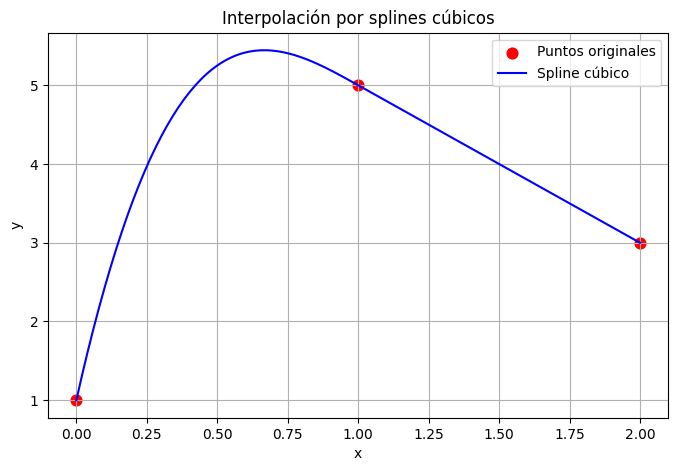

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

# Definir los puntos
xs = [0, 1, 2]
ys = [1, 5, 3]

# Generar los splines
splines = cubic_spline(xs=xs, ys=ys)

# Graficar los puntos y el spline
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(xs, ys, color='red', s=60, label='Puntos originales')

x = sym.Symbol('x')
x_vals = np.linspace(min(xs), max(xs), 200)
y_vals = []
for x_val in x_vals:
    idx = 0
    for i in range(len(xs)-1):
        if xs[i] <= x_val <= xs[i+1]:
            idx = i
            break
    spline_func = sym.lambdify(x, splines[idx])
    y_vals.append(spline_func(x_val))
ax.plot(x_vals, y_vals, 'b-', label='Spline cúbico')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Interpolación por splines cúbicos')
ax.grid(True)
ax.legend()
plt.show()

1 -4 7.0 0.0 0.0
0 -5 -11.0 18.0 -6.0


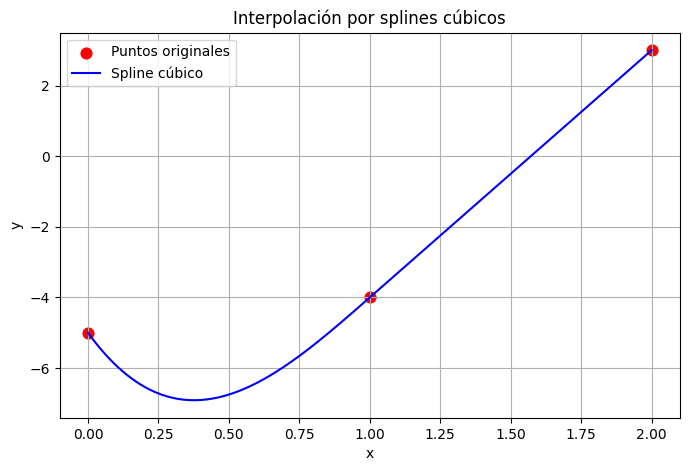

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

# Definir los puntos
xs = [0, 1, 2]
ys = [-5, -4, 3]

# Generar los splines
splines = cubic_spline(xs=xs, ys=ys)

# Graficar los puntos y el spline
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(xs, ys, color='red', s=60, label='Puntos originales')

x = sym.Symbol('x')
x_vals = np.linspace(min(xs), max(xs), 200)
y_vals = []
for x_val in x_vals:
    idx = 0
    for i in range(len(xs)-1):
        if xs[i] <= x_val <= xs[i+1]:
            idx = i
            break
    spline_func = sym.lambdify(x, splines[idx])
    y_vals.append(spline_func(x_val))
ax.plot(x_vals, y_vals, 'b-', label='Spline cúbico')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Interpolación por splines cúbicos')
ax.grid(True)
ax.legend()
plt.show()

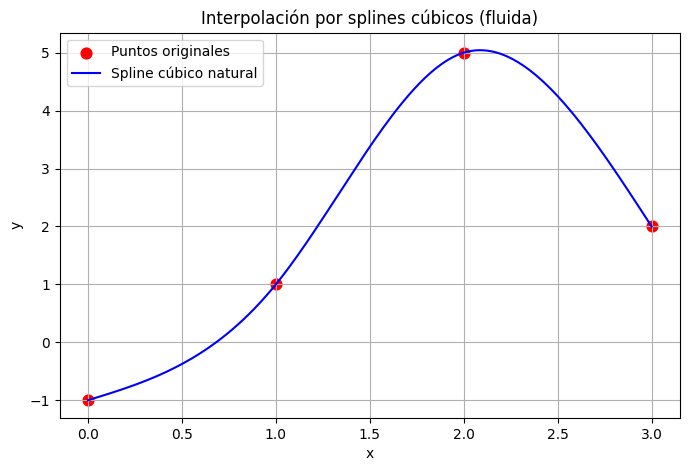

In [ ]:
from scipy.interpolate import CubicSpline

# Definir los puntos
xs = [0, 1, 2, 3]
ys = [-1, 1, 5, 2]

# Spline cúbico natural
cs = CubicSpline(xs, ys, bc_type='natural')

x_vals = np.linspace(min(xs), max(xs), 200)
y_vals = cs(x_vals)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(xs, ys, color='red', s=60, label='Puntos originales')
ax.plot(x_vals, y_vals, 'b-', label='Spline cúbico natural')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Interpolación por splines cúbicos (fluida)')
ax.grid(True)
ax.legend()
plt.show()


## Para cada uno de los ejercicios anteriores, resuelva los splines cúbicos de frontera condicionada con B0=1 para todos los valores de B1∈R

Spline en [0,1]:


x**3*(19/4 - B1/4) + x**2*(B1/4 - 19/4) + x - 5

Spline en [1,2]:


(23/4 - B1/4)*(x - 1) + (19/2 - B1/2)*(x - 1)**2 + (3*B1/4 - 33/4)*(x - 1)**3 - 4

Ambos en función de B1 (derivada en x=2)


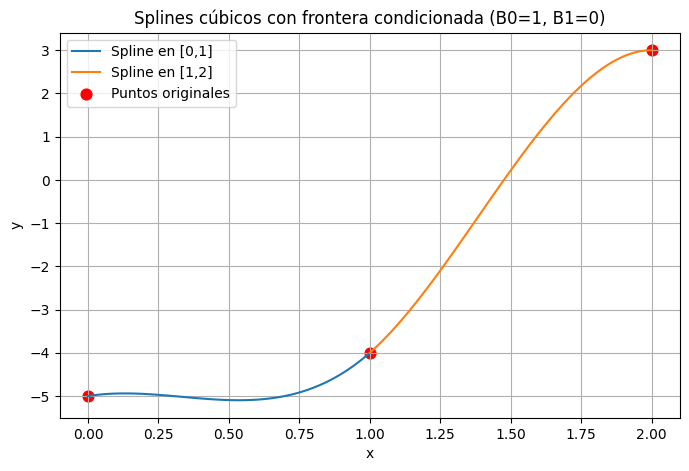

In [ ]:
# Cambiar los puntos a (0, -5), (1, -4), (2, 3)
xs = [0, 1, 2]
ys = [-5, -4, 3]

# Símbolos para las incógnitas de los coeficientes y la derivada final B1
a0, b0, c0, d0 = symbols('a0 b0 c0 d0')
a1, b1, c1, d1 = symbols('a1 b1 c1 d1')
B1 = symbols('B1')  # Derivada en el extremo derecho (puede ser cualquier real)

# Ecuaciones para el primer intervalo [x0, x1]
eqs = [
    Eq(a0, ys[0]),  # S0(x0) = y0
    Eq(a0 + b0*(xs[1]-xs[0]) + c0*(xs[1]-xs[0])**2 + d0*(xs[1]-xs[0])**3, ys[1]),  # S0(x1) = y1
    Eq(b0, 1),  # Condición de frontera izquierda: S0'(x0) = B0 = 1
]

# Ecuaciones para el segundo intervalo [x1, x2]
eqs += [
    Eq(a1, ys[1]),  # S1(x1) = y1
    Eq(a1 + b1*(xs[2]-xs[1]) + c1*(xs[2]-xs[1])**2 + d1*(xs[2]-xs[1])**3, ys[2]),  # S1(x2) = y2
    Eq(b1 + 2*c1*(xs[2]-xs[1]) + 3*d1*(xs[2]-xs[1])**2, B1),  # Condición de frontera derecha: S1'(x2) = B1
]

# Condiciones de suavidad en x1
h0 = xs[1] - xs[0]
h1 = xs[2] - xs[1]
# Primera derivada continua en x1
eqs.append(Eq(
    b0 + 2*c0*h0 + 3*d0*h0**2,
    b1
))
# Segunda derivada continua en x1
eqs.append(Eq(
    2*c0 + 6*d0*h0,
    2*c1
))

# Resolver el sistema para los coeficientes en función de B1
sol = solve(eqs, [a0, b0, c0, d0, a1, b1, c1, d1])

# Mostrar los polinomios de los splines en función de B1
x = symbols('x')
S0 = sol[a0] + sol[b0]*(x-xs[0]) + sol[c0]*(x-xs[0])**2 + sol[d0]*(x-xs[0])**3
S1 = sol[a1] + sol[b1]*(x-xs[1]) + sol[c1]*(x-xs[1])**2 + sol[d1]*(x-xs[1])**3

print("Spline en [0,1]:")
display(S0)
print("Spline en [1,2]:")
display(S1)
print("Ambos en función de B1 (derivada en x=2)")

# Crear funciones numéricas a partir de los polinomios simbólicos S0 y S1
S0_func = lambdify(x, S0.subs(B1, 0), modules='numpy')  # Puedes cambiar B1 por otro valor si lo deseas
S1_func = lambdify(x, S1.subs(B1, 0), modules='numpy')

# Rango de x para cada intervalo
x0_vals = np.linspace(xs[0], xs[1], 100)
x1_vals = np.linspace(xs[1], xs[2], 100)

# Evaluar los splines en cada intervalo
y0_vals = S0_func(x0_vals)
y1_vals = S1_func(x1_vals)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x0_vals, y0_vals, label='Spline en [0,1]')
plt.plot(x1_vals, y1_vals, label='Spline en [1,2]')
plt.scatter(xs, ys, color='red', s=60, label='Puntos originales')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Splines cúbicos con frontera condicionada (B0=1, B1=0)')
plt.legend()
plt.grid(True)
plt.show()

Spline en [0,1]:


x**3*(B1/15 + 4/3) + x**2*(-B1/15 - 1/3) + x - 1

Spline en [1,2]:


(-B1/5 - 4)*(x - 1)**3 + (B1/15 + 13/3)*(x - 1) + (2*B1/15 + 11/3)*(x - 1)**2 + 1

Spline en [2,3]:


(-7*B1/15 - 25/3)*(x - 2)**2 + (-4*B1/15 - 1/3)*(x - 2) + (11*B1/15 + 17/3)*(x - 2)**3 + 5

Todos en función de B1 (derivada en x=3)


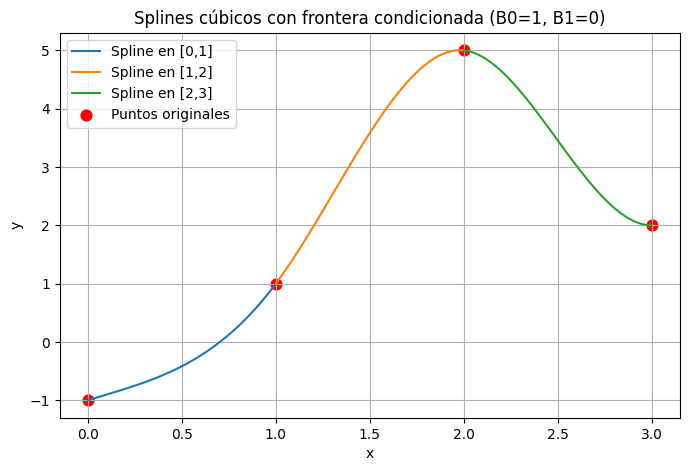

In [ ]:
# Cambiar los puntos a (0, -1), (1, 1), (2, 5), (3, 2)
xs = [0, 1, 2, 3]
ys = [-1, 1, 5, 2]

# Símbolos para las incógnitas de los coeficientes y la derivada final B1
a0, b0, c0, d0 = symbols('a0 b0 c0 d0')
a1, b1, c1, d1 = symbols('a1 b1 c1 d1')
a2, b2, c2, d2 = symbols('a2 b2 c2 d2')
B1 = symbols('B1')  # Derivada en el extremo derecho (puede ser cualquier real)

# Ecuaciones para el primer intervalo [x0, x1]
eqs = [
    Eq(a0, ys[0]),  # S0(x0) = y0
    Eq(a0 + b0*(xs[1]-xs[0]) + c0*(xs[1]-xs[0])**2 + d0*(xs[1]-xs[0])**3, ys[1]),  # S0(x1) = y1
    Eq(b0, 1),  # Condición de frontera izquierda: S0'(x0) = B0 = 1
]

# Ecuaciones para el segundo intervalo [x1, x2]
eqs += [
    Eq(a1, ys[1]),  # S1(x1) = y1
    Eq(a1 + b1*(xs[2]-xs[1]) + c1*(xs[2]-xs[1])**2 + d1*(xs[2]-xs[1])**3, ys[2]),  # S1(x2) = y2
]

# Ecuaciones para el tercer intervalo [x2, x3]
eqs += [
    Eq(a2, ys[2]),  # S2(x2) = y2
    Eq(a2 + b2*(xs[3]-xs[2]) + c2*(xs[3]-xs[2])**2 + d2*(xs[3]-xs[2])**3, ys[3]),  # S2(x3) = y3
    Eq(b2 + 2*c2*(xs[3]-xs[2]) + 3*d2*(xs[3]-xs[2])**2, B1),  # Condición de frontera derecha: S2'(x3) = B1
]

# Condiciones de suavidad en x1 y x2
h0 = xs[1] - xs[0]
h1 = xs[2] - xs[1]
h2 = xs[3] - xs[2]

# Primera derivada continua en x1
eqs.append(Eq(
    b0 + 2*c0*h0 + 3*d0*h0**2,
    b1
))
# Segunda derivada continua en x1
eqs.append(Eq(
    2*c0 + 6*d0*h0,
    2*c1
))

# Primera derivada continua en x2
eqs.append(Eq(
    b1 + 2*c1*h1 + 3*d1*h1**2,
    b2
))
# Segunda derivada continua en x2
eqs.append(Eq(
    2*c1 + 6*d1*h1,
    2*c2
))

# Resolver el sistema para los coeficientes en función de B1
sol = solve(
    eqs,
    [a0, b0, c0, d0, a1, b1, c1, d1, a2, b2, c2, d2],
    dict=True
)[0]

# Mostrar los polinomios de los splines en función de B1
x = symbols('x')
S0 = sol[a0] + sol[b0]*(x-xs[0]) + sol[c0]*(x-xs[0])**2 + sol[d0]*(x-xs[0])**3
S1 = sol[a1] + sol[b1]*(x-xs[1]) + sol[c1]*(x-xs[1])**2 + sol[d1]*(x-xs[1])**3
S2 = sol[a2] + sol[b2]*(x-xs[2]) + sol[c2]*(x-xs[2])**2 + sol[d2]*(x-xs[2])**3

print("Spline en [0,1]:")
display(S0)
print("Spline en [1,2]:")
display(S1)
print("Spline en [2,3]:")
display(S2)
print("Todos en función de B1 (derivada en x=3)")

# Crear funciones numéricas a partir de los polinomios simbólicos S0, S1, S2
S0_func = lambdify(x, S0.subs(B1, 0), modules='numpy')  # Puedes cambiar B1 por otro valor si lo deseas
S1_func = lambdify(x, S1.subs(B1, 0), modules='numpy')
S2_func = lambdify(x, S2.subs(B1, 0), modules='numpy')

# Rango de x para cada intervalo
x0_vals = np.linspace(xs[0], xs[1], 100)
x1_vals = np.linspace(xs[1], xs[2], 100)
x2_vals = np.linspace(xs[2], xs[3], 100)

# Evaluar los splines en cada intervalo
y0_vals = S0_func(x0_vals)
y1_vals = S1_func(x1_vals)
y2_vals = S2_func(x2_vals)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x0_vals, y0_vals, label='Spline en [0,1]')
plt.plot(x1_vals, y1_vals, label='Spline en [1,2]')
plt.plot(x2_vals, y2_vals, label='Spline en [2,3]')
plt.scatter(xs, ys, color='red', s=60, label='Puntos originales')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Splines cúbicos con frontera condicionada (B0=1, B1=0)')
plt.legend()
plt.grid(True)
plt.show()

# Realice una animación de la variación de los splines cúbicos al variar B1

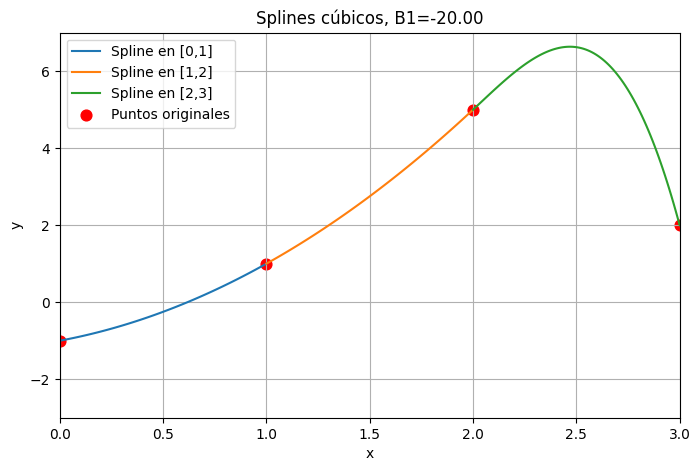

In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation
from sympy import lambdify

import matplotlib.pyplot as plt

# Usar los polinomios S0, S1, S2 ya definidos en función de B1 y x
# xs y ys ya están definidos: xs = [0, 1, 2, 3], ys = [-1, 1, 5, 2]

# Rango de valores para B1
B1_vals = np.linspace(-20, 20, 100)

# Preparar los rangos de x para cada intervalo
x0_vals = np.linspace(xs[0], xs[1], 100)
x1_vals = np.linspace(xs[1], xs[2], 100)
x2_vals = np.linspace(xs[2], xs[3], 100)

fig, ax = plt.subplots(figsize=(8, 5))
line0, = ax.plot([], [], label='Spline en [0,1]')
line1, = ax.plot([], [], label='Spline en [1,2]')
line2, = ax.plot([], [], label='Spline en [2,3]')
points = ax.scatter(xs, ys, color='red', s=60, label='Puntos originales')
title = ax.set_title('')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.grid(True)
ax.set_xlim(min(xs), max(xs))
ax.set_ylim(min(ys)-2, max(ys)+2)

def animate(i):
    B1_val = B1_vals[i]
    S0_func = lambdify(x, S0.subs(B1, B1_val), modules='numpy')
    S1_func = lambdify(x, S1.subs(B1, B1_val), modules='numpy')
    S2_func = lambdify(x, S2.subs(B1, B1_val), modules='numpy')
    line0.set_data(x0_vals, S0_func(x0_vals))
    line1.set_data(x1_vals, S1_func(x1_vals))
    line2.set_data(x2_vals, S2_func(x2_vals))
    title.set_text(f'Splines cúbicos, B1={B1_val:.2f}')
    return line0, line1, line2, title

ani = FuncAnimation(fig, animate, frames=len(B1_vals), interval=60, blit=True)
plt.show()